#Importing Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive




#Mounting dataset

In [ ]:

from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define File Path (Update this if needed)
file_path = "/content/drive/My Drive/dataset/Anomalydata.csv"

# Load the CSV File
data = pd.read_csv(file_path)

# Display Dataset Info
print("Dataset Shape:", data.shape)
print(data.head())



Mounted at /content/drive
Dataset Shape: (763144, 16)
     timestamp  processId  threadId  parentProcessId  userId  mountNamespace  \
0  1809.495787        381      7337                1     100      4026532231   
1  1809.495832        381      7337                1     100      4026532231   
2  1809.495921        381      7337                1     100      4026532231   
3  1894.139651       7347      7347             7341       0      4026531840   
4  1894.142127       7347      7347             7341       0      4026531840   

  processName         hostName  eventId           eventName  \
0       close  ip-10-100-1-120      157               prctl   
1       close  ip-10-100-1-120        3               close   
2       close  ip-10-100-1-120     1010  sched_process_exit   
3          sh  ip-10-100-1-120       21              access   
4          sh  ip-10-100-1-120     1005  security_file_open   

                         stackAddresses  argsNum  returnValue  \
0  [140662171848350, 

#Preprocessing

In [ ]:
print("\nMissing values:")
print(data.isnull().sum())



Missing values:
timestamp          0
processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
processName        0
hostName           0
eventId            0
eventName          0
stackAddresses     0
argsNum            0
returnValue        0
args               0
sus                0
evil               0
dtype: int64


# Separate numeric and categorical columns


In [ ]:

numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

print("\nNumeric columns:", numeric_columns.tolist())
print("Categorical columns:", categorical_columns.tolist())




Numeric columns: ['timestamp', 'processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'sus', 'evil']
Categorical columns: ['processName', 'hostName', 'eventName', 'stackAddresses', 'args']


#Exploratory Data Analysis

# Box plots to check outliers

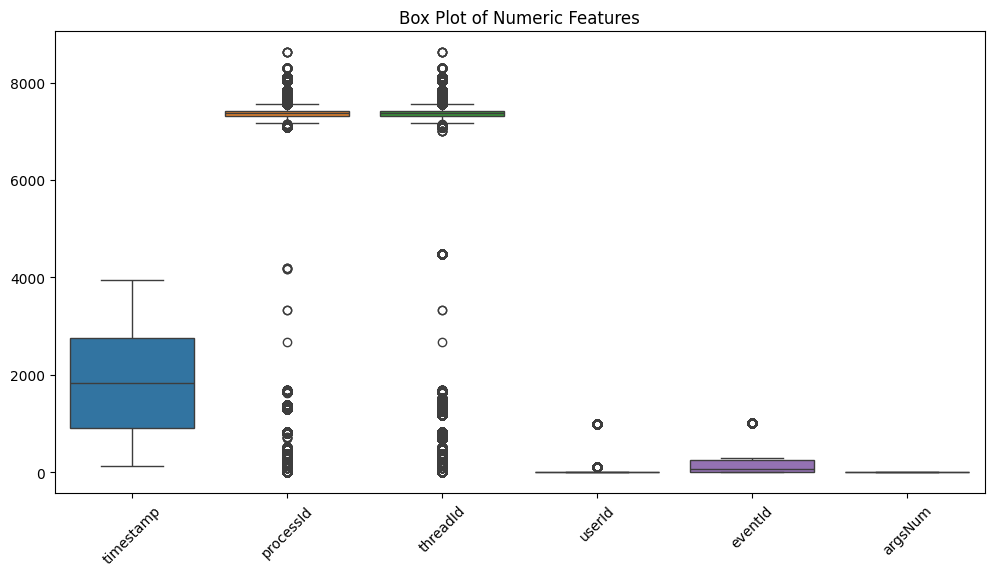

In [ ]:

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['timestamp', 'processId', 'threadId', 'userId', 'eventId', 'argsNum']])
plt.xticks(rotation=45)
plt.title("Box Plot of Numeric Features")
plt.show()

#Top Process Names (Bar Plot)

<ipython-input-6-1fbe8a1b62b3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_processes.index, y=top_processes.values, palette="viridis")


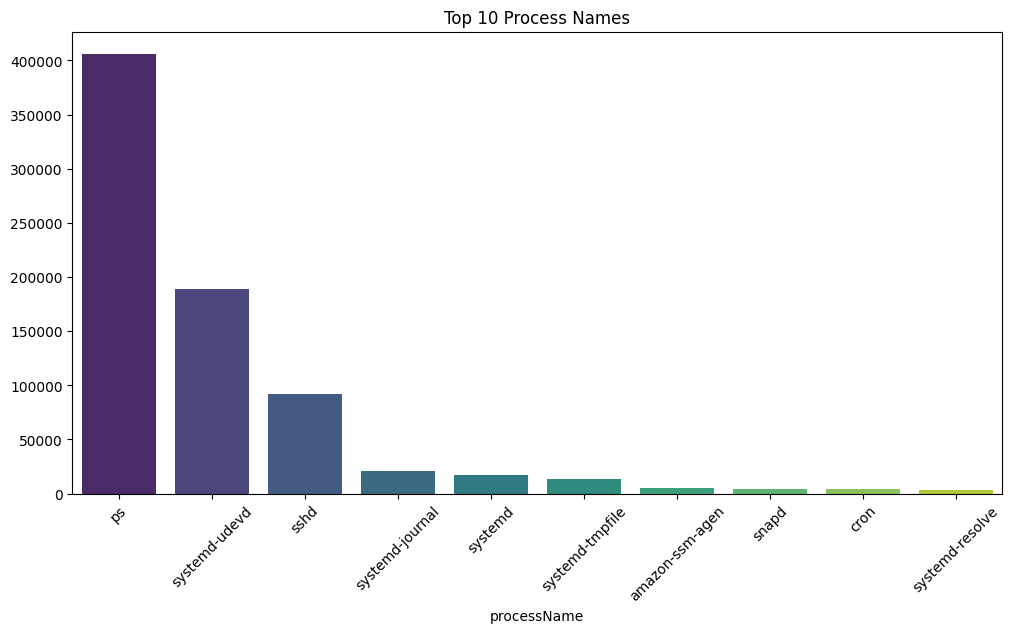

In [ ]:

plt.figure(figsize=(12, 6))
top_processes = data['processName'].value_counts().nlargest(10)  # Top 10
sns.barplot(x=top_processes.index, y=top_processes.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Process Names")
plt.show()

## Event Name Distribution


<ipython-input-7-b45a586c3c6f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.index, y=top_events.values, palette="coolwarm")


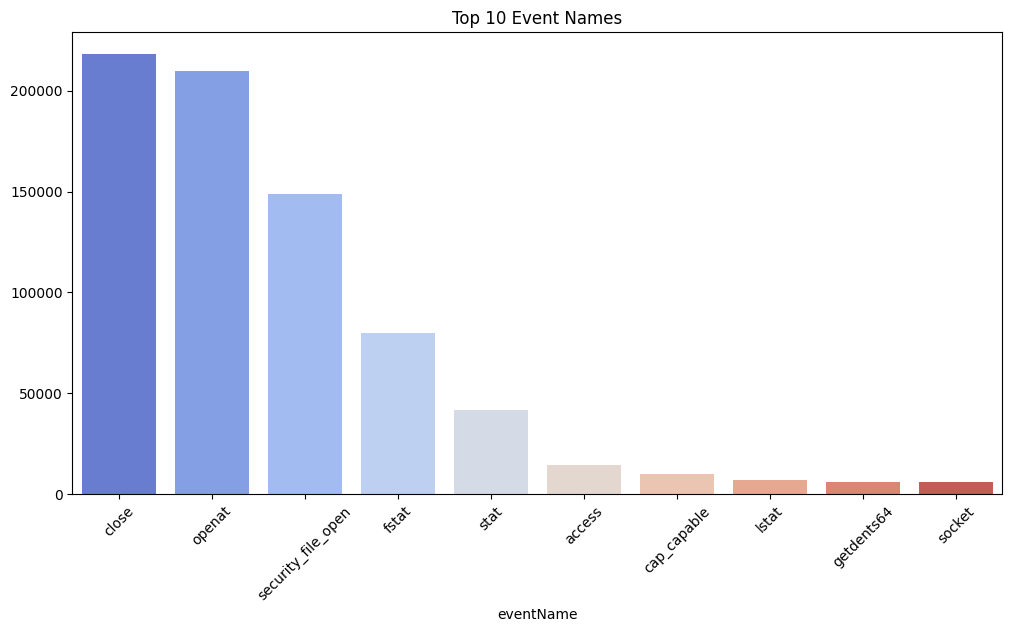

In [ ]:
plt.figure(figsize=(12, 6))
top_events = data['eventName'].value_counts().nlargest(10)  # Top 10
sns.barplot(x=top_events.index, y=top_events.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Event Names")
plt.show()

# Handle missing values


In [ ]:
if len(numeric_columns) > 0:
    data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())
if len(categorical_columns) > 0:
    data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])


# Encode categorical features


In [ ]:
le_dict = {}
for col in categorical_columns:
    le_dict[col] = LabelEncoder()
    data[col] = le_dict[col].fit_transform(data[col])

# Feature-target split (using 'evil' as target)


In [ ]:
X = data.drop(['evil', 'sus'], axis=1)  # Dropping both 'evil' and 'sus' columns
y = data['evil']

# Split the dataset


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop(['evil', 'sus'], axis=1))  # Dropping 'evil' and 'sus'



#ISOLATION FOREST

In [ ]:
# ------------------------------ ISOLATION FOREST ------------------------------
print("\n🔹 Training Isolation Forest model...")
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_predictions = iso_forest.fit_predict(X_scaled)

# Convert output to binary
data['iso_anomaly'] = [1 if x == -1 else 0 for x in iso_predictions]

# Evaluation
iso_acc = accuracy_score(data['evil'], data['iso_anomaly'])
print("\n🔹 Isolation Forest Accuracy:", round(iso_acc * 100, 2), "%")






🔹 Training Isolation Forest model...

🔹 Isolation Forest Accuracy: 90.0 %


#Anomaly Score Distribution (Decision Function)


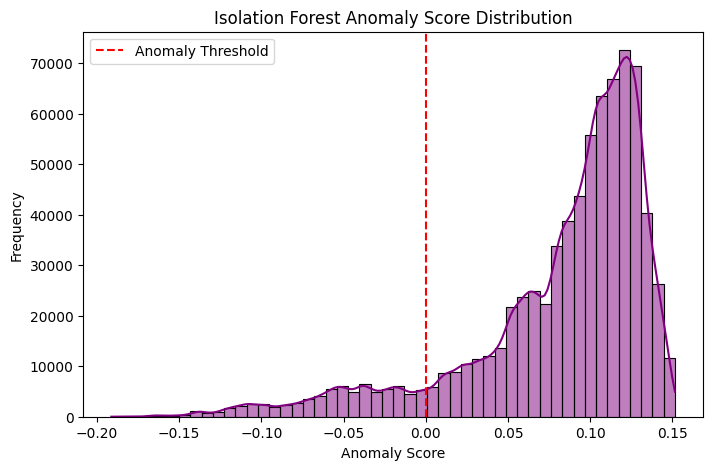

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

iso_scores = iso_forest.decision_function(X_scaled)  # Get anomaly scores
plt.figure(figsize=(8, 5))
sns.histplot(iso_scores, bins=50, kde=True, color='purple')
plt.axvline(np.percentile(iso_scores, 10), color='red', linestyle='dashed', label="Anomaly Threshold")
plt.title("Isolation Forest Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()





# Anomalies Across Key Features

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


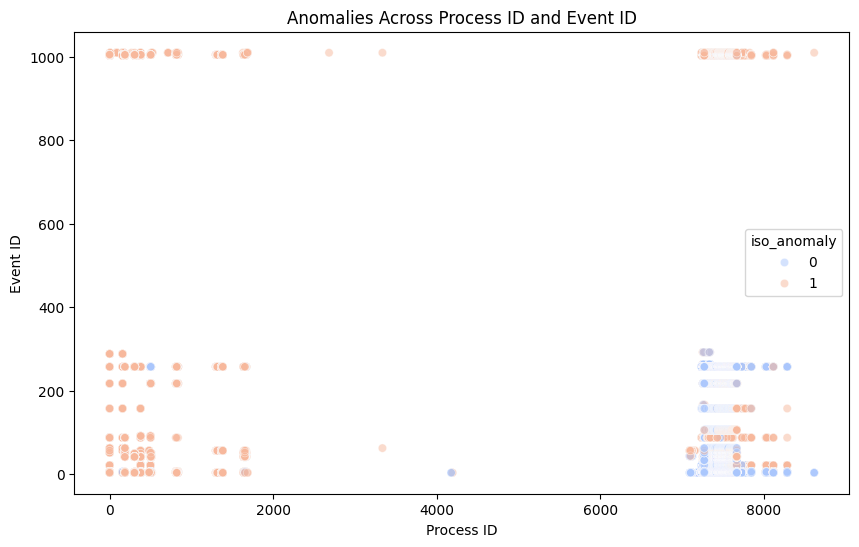

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['processId'], y=data['eventId'], hue=data['iso_anomaly'], palette="coolwarm", alpha=0.5)
plt.title("Anomalies Across Process ID and Event ID")
plt.xlabel("Process ID")
plt.ylabel("Event ID")
plt.show()


In [ ]:
#  Classification Report
print("\n🔹 Classification Report:\n")
print(classification_report(data['evil'], data['iso_anomaly']))


🔹 Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    763144
           1       0.00      0.00      0.00         0

    accuracy                           0.90    763144
   macro avg       0.50      0.45      0.47    763144
weighted avg       1.00      0.90      0.95    763144



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# LOCAL OUTLIER FACTOR (LOF)

In [ ]:
# ------------------------------ LOCAL OUTLIER FACTOR (LOF) ------------------------------
from sklearn.neighbors import LocalOutlierFactor

print("\n🔹 Training Local Outlier Factor (LOF) model...")

# Define LOF with optimized parameters
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, metric='euclidean')

# Fit and predict
lof_predictions = lof.fit_predict(X_scaled)

# Convert output to binary
data['lof_anomaly'] = (lof_predictions == -1).astype(int)

# Evaluation
lof_acc = accuracy_score(data['evil'], data['lof_anomaly'])
print("\n🔹 Local Outlier Factor Accuracy:", round(lof_acc * 100, 2), "%")



🔹 Training Local Outlier Factor (LOF) model...

🔹 Local Outlier Factor Accuracy: 95.0 %



#LOF Anomalies Across Key Features

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


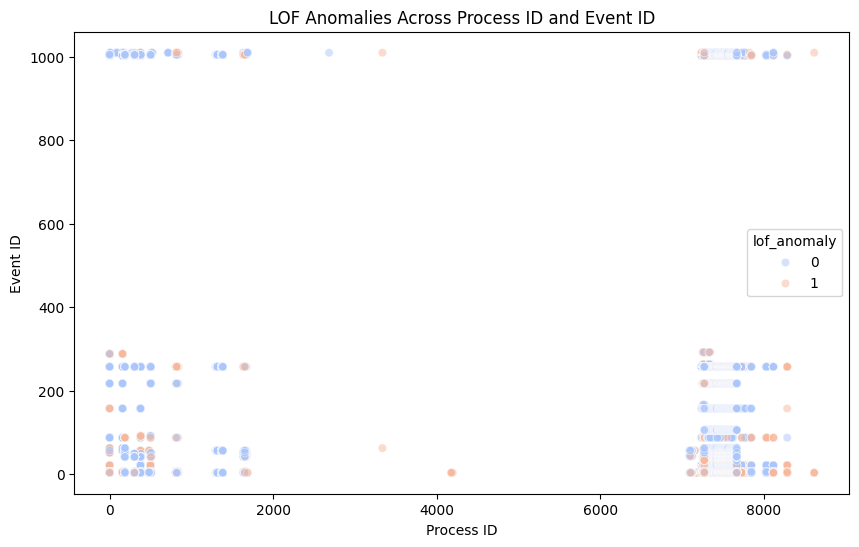

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report


plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['processId'], y=data['eventId'], hue=data['lof_anomaly'], palette="coolwarm", alpha=0.5)
plt.title("LOF Anomalies Across Process ID and Event ID")
plt.xlabel("Process ID")
plt.ylabel("Event ID")
plt.show()


#Classification Report

In [ ]:

print("\n🔹 Classification Report for LOF:\n")
print(classification_report(data['evil'], data['lof_anomaly']))


🔹 Classification Report for LOF:

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    763144
           1       0.00      0.00      0.00         0

    accuracy                           0.95    763144
   macro avg       0.50      0.47      0.49    763144
weighted avg       1.00      0.95      0.97    763144



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#One-Class SVM

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("\n🔹 Training Optimized One-Class SVM model...")

# Reduce dimensionality with PCA (5 components for speed)
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X_scaled)

# Train One-Class SVM with faster parameters
svm_model = OneClassSVM(kernel='linear', nu=0.05, shrinking=False)  # Using 'linear' for speed
svm_predictions = svm_model.fit_predict(X_reduced)

# Convert output to binary
data['svm_anomaly'] = (svm_predictions == -1).astype(int)

# Evaluation
svm_acc = accuracy_score(data['evil'], data['svm_anomaly'])
print("\n🔹 Optimized One-Class SVM Accuracy:", round(svm_acc * 100, 2), "%")



🔹 Training Optimized One-Class SVM model...

🔹 Optimized One-Class SVM Accuracy: 69.44 %



# Anomaly Distribution

<ipython-input-20-c5896ff5b7a1>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['svm_anomaly'], palette="coolwarm")


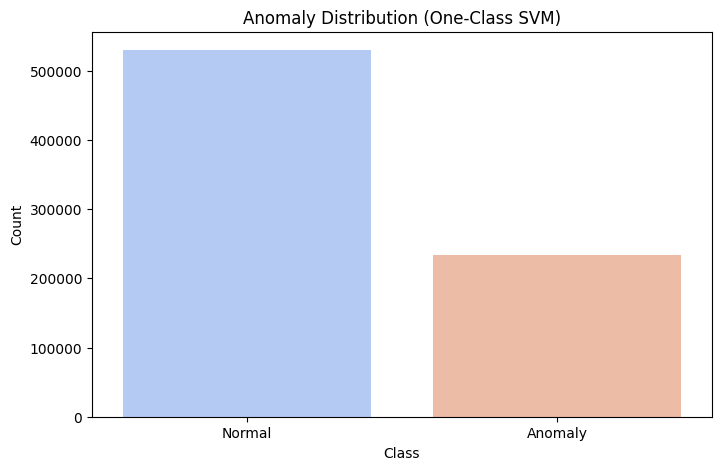

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report


plt.figure(figsize=(8, 5))
sns.countplot(x=data['svm_anomaly'], palette="coolwarm")
plt.xticks([0, 1], labels=["Normal", "Anomaly"])
plt.title("Anomaly Distribution (One-Class SVM)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()





#Anomalies Across Features


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


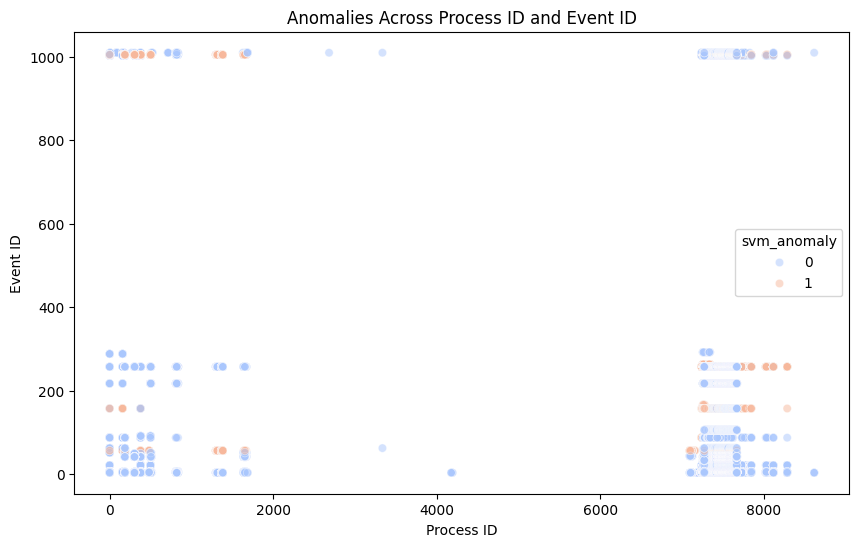

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['processId'], y=data['eventId'], hue=data['svm_anomaly'], palette="coolwarm", alpha=0.5)
plt.title("Anomalies Across Process ID and Event ID")
plt.xlabel("Process ID")
plt.ylabel("Event ID")
plt.show()

In [ ]:

# Classification Report
print("\n🔹 Classification Report for One-Class SVM:\n")
print(classification_report(data['evil'], data['svm_anomaly']))


🔹 Classification Report for One-Class SVM:

              precision    recall  f1-score   support

           0       1.00      0.69      0.82    763144
           1       0.00      0.00      0.00         0

    accuracy                           0.69    763144
   macro avg       0.50      0.35      0.41    763144
weighted avg       1.00      0.69      0.82    763144



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#COMPARE RESULTS IN BAR CHART

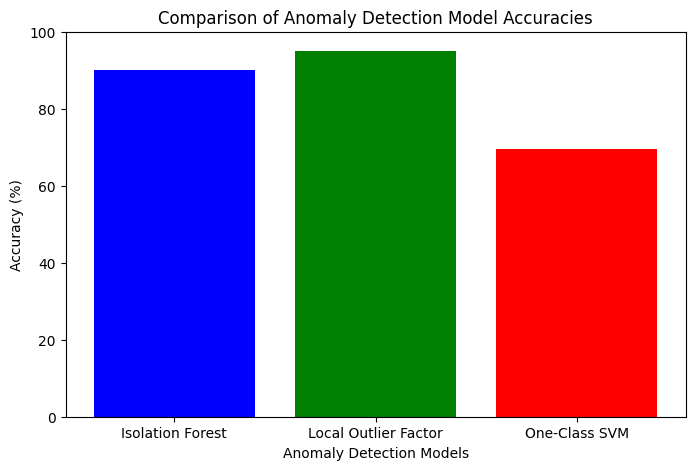

In [ ]:
# ------------------------------ COMPARE RESULTS IN BAR CHART ------------------------------
models = ["Isolation Forest", "Local Outlier Factor", "One-Class SVM"]
accuracies = [iso_acc * 100, lof_acc * 100, svm_acc * 100]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel("Anomaly Detection Models")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Anomaly Detection Model Accuracies")
plt.ylim(0, 100)
plt.show()